<a href="https://colab.research.google.com/github/tsubasa05/Poker-Stats-Machine-learning/blob/main/poker_stats_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
%tensorflow_version 2.x

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
#ライブラリーのインポート、初期設定
import os
import numpy as np
import random as rn
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
rn.seed(0)

session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [76]:
#ドライブからデータを持ってくる
df = pd.read_csv('/content/drive/My Drive/sample all.csv')
alldata = pd.read_csv('/content/drive/My Drive/allhand all.csv')

In [77]:
#必要のないコラムを削除
df.drop(['Source.Name','Total Hands','bb/100','All-in Adj bb/100'], axis=1,inplace=True)

In [78]:
#かぶりのある行の排除
for i in range(0,len(df)-1,3):
  df.drop(index=[i+1],inplace=True)
  df.drop(index=[i+2],inplace=True)

In [79]:
#かぶりのある行の排除
for i in range(0,len(alldata)-1,3):
  alldata.drop(index=[i+1],inplace=True)
  alldata.drop(index=[i+2],inplace=True)

In [80]:
#alldataをプレイヤー名と成績のみのリストに変える
N1 = alldata.loc[:,'All-in Adj bb/100']
N2 = alldata.loc[:,'Player']

alldata2 = pd.concat([N1, N2],axis=1)

In [81]:
alldata2.mean()

All-in Adj bb/100    3.9908
dtype: float64

In [82]:
#ラベルとプレイヤーの統計を結合する。ラベルは'All-in Adj bb/100'が3.72(プレイヤーの平均値)より小さい場合は0,大きい場合は1とする
df['label']=0
for i in range(0,len(df)-1,1):
  for k in range(0,len(alldata2)-1,1):
    if alldata2.iat[k,1] == df.iat[i,0]:
      if alldata2.iat[k,0] >= 3.99:
        df.iat[i,len(df.columns)-1]=1

In [83]:
#player名の列を削除
df.drop(['Player'], axis=1,inplace=True)

In [84]:
#欠測値が10以上の列を削除
s = df.isnull().sum()
df.loc['欠測地'] = s

df.sort_values(by='欠測地', axis=1, ascending=True, inplace=True)

for i in df.columns.values:
  if df.at['欠測地',i]>10:
    df.drop(columns=i,inplace=True)

In [85]:
#欠測値列の排除
df.drop(index=['欠測地'],inplace=True)

In [86]:
#特徴量と教師に分ける
#教師データ
Y = df.loc[:,'label'].values
#特徴量データから教師データを削除
df.drop(columns='label',inplace=True)
#特徴量データの作成
X = df.loc[:,:].values

**学習の特徴量として使用する統計はサンプル数が100以上集まったものを利用する**

In [87]:
#学習に利用する統計のみ特徴量として抽出する
X = df.loc[:,['VPIP','Limp','PFR','Cold Call','3bet In Position','3bet Out of Position','Fold to 3Bet IP','Fold to 3Bet OOP','4Bet IP','4Bet OOP','Fold to 4Bet','5Bet (Raise 4Bet)','WTSD%','W$WSF','W$SD%','Agg','River Call Efficiency','Flop CBet IP%','Flop CBet OOP%','Flop Fold vs Cbet OOP','Flop Raise Cbet OOP','Flop Fold vs Cbet IP','Flop Raise Cbet IP','Bet Turn OOP vs Missed Flop CBet OOP','Turn CBet IP%','Turn CBet OOP%','Bet Flop vs Missed CBet','Fold Turn IP Skip CBet','Delayed Turn CBet% OOP','Check Fold Flop% As PFR','Check Raise Flop% As PFR','Delayed Turn CBet% IP','Turn Fold vs Cbet OOP','Bet River OOP vs Missed Turn CBet OOP','Turn Fold vs Cbet IP','Skip Turn CB and Fold To River Bet IP','Check Fold Turn OOP Skip CBet','Check Raise Turn OOP Skip CBet','Bet Turn IP vs Missed CBet','Flop CBet-Fold IP TOT','Flop CBet-Fold OOP TOT','River CBet OOP%','River CBet IP%']].values

In [88]:
#欠測値を平均値で補完
from sklearn.impute import SimpleImputer

imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(X)
X = imr.transform(X)

In [95]:
#データを訓練用とテスト用に分割
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.35, random_state=0)

In [96]:
#データの標準化
mean = X_train.mean(axis=0)
X_train -= mean
std = X_train.std(axis=0)
X_train /= std

X_test -= mean
X_test /= std

# モデルの選択および学習

In [97]:
#ニューラルネットワークによる分類モデル
from tensorflow.keras import layers, models

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(50, activation='relu',
                           input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dense(1,activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    return model

In [98]:
#4分割交差検証
k = 4
num_val_samples = len(X_train) // k
num_epochs = 300
all_scores = []
all_acc_histories = []
all_val_acc_histories = []
for i in range(k):
    print('processing fold #', i)
    
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [X_train[:i * num_val_samples],
         X_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs,batch_size=1, verbose=0)
    
    acc_history = history.history['acc']
    val_acc_history = history.history['val_acc']
    all_acc_histories.append(acc_history)
    all_val_acc_histories.append(val_acc_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


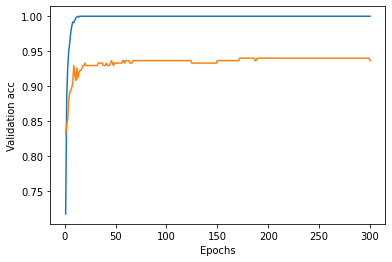

acc: 1.0 val_acc: 0.9366197288036346


In [99]:
#モデルの訓練用データ、検証用データの正解率
average_acc_history = [
    np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]

average_val_acc_history = [
    np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

plt.plot(range(1, len(average_acc_history) + 1), average_acc_history)
plt.plot(range(1, len(average_val_acc_history) + 1), average_val_acc_history)
plt.xlabel('Epochs')
plt.ylabel('Validation acc')
plt.show()
print('acc:',average_acc_history[num_epochs-1],'val_acc:',average_val_acc_history[num_epochs-1])

In [100]:
#テストデータによる評価
test_mse_score, test_mae_score = model.evaluate(X_test, y_test)
print(test_mse_score,test_mae_score)

5/5 [==============================] - 0s 3ms/step - loss: 0.2221 - acc: 0.9551
0.2221355438232422 0.9551281929016113


In [101]:
#非線形SVMによる分類
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
k = 4

def train_model(X_train, y_train, X_dev, y_dev):
    best_c, best_gamma, best_score = 0, 0, 0
    for c in [0.1, 1, 10]:
      for g in [0.001, 0.0001]:
        classifier = SVC(kernel='rbf', random_state=0, gamma=g, C=c)
        classifier.fit(X_train, y_train)
        dev_acc = accuracy_score(y_dev, classifier.predict(X_dev))
        if best_score < dev_acc:
            best_score = dev_acc
            best_c = c
            best_gamma = g
        print("Dev accuracy = %1.3f\tgamma = %s C = %s" % (dev_acc, str(g), str(c)))
    print("Best parameter: accuracy = %f\tgamma = %s C = %s" % (best_score,str(best_gamma), str(best_c)))
    return best_c, best_gamma

for i in range(k):
    print('processing fold #', i)
    
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [X_train[:i * num_val_samples],
         X_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)
    
    best_c, best_gamma = train_model(partial_train_data, partial_train_targets, val_data, val_targets)

processing fold # 0
Dev accuracy = 0.577	gamma = 0.001 C = 0.1
Dev accuracy = 0.577	gamma = 0.0001 C = 0.1
Dev accuracy = 0.845	gamma = 0.001 C = 1
Dev accuracy = 0.577	gamma = 0.0001 C = 1
Dev accuracy = 0.930	gamma = 0.001 C = 10
Dev accuracy = 0.845	gamma = 0.0001 C = 10
Best parameter: accuracy = 0.929577	gamma = 0.001 C = 10
processing fold # 1
Dev accuracy = 0.507	gamma = 0.001 C = 0.1
Dev accuracy = 0.507	gamma = 0.0001 C = 0.1
Dev accuracy = 0.606	gamma = 0.001 C = 1
Dev accuracy = 0.507	gamma = 0.0001 C = 1
Dev accuracy = 0.803	gamma = 0.001 C = 10
Dev accuracy = 0.606	gamma = 0.0001 C = 10
Best parameter: accuracy = 0.802817	gamma = 0.001 C = 10
processing fold # 2
Dev accuracy = 0.437	gamma = 0.001 C = 0.1
Dev accuracy = 0.437	gamma = 0.0001 C = 0.1
Dev accuracy = 0.690	gamma = 0.001 C = 1
Dev accuracy = 0.437	gamma = 0.0001 C = 1
Dev accuracy = 0.817	gamma = 0.001 C = 10
Dev accuracy = 0.718	gamma = 0.0001 C = 10
Best parameter: accuracy = 0.816901	gamma = 0.001 C = 10
proc

In [102]:
def eval_model(X_train, y_train, X_test, y_test, best_c):
    classifier = SVC(kernel='rbf', random_state=0, gamma=best_gamma, C=best_c)
    classifier.fit(X_train, y_train)
    test_acc = accuracy_score(y_test, classifier.predict(X_test))
    print("Test accuracy = %1.3f" % test_acc)

eval_model(X_train, y_train, X_test, y_test, best_c)

Test accuracy = 0.897


**Permutation Importance**


> 検証用データの1つの特徴量の値をランダムに入れ替え、モデルに適用して正解率を出し、どのように特徴量が正解率に影響を与えているかを確認する



In [103]:
#Permutation Importance
all_Permutation_acc = np.empty(X.shape[1])

for m in range(X_test.shape[1]):
  ss=X_test
  hh=ss[:,m]
  ss=np.delete(ss,m,1)
  hh=np.random.permutation(hh)
  tt=np.insert(ss, m, hh, axis=1)
  test_mse_score, test_mae_score = model.evaluate(tt,y_test)
  all_Permutation_acc[m]=test_mae_score

5/5 [==============================] - 0s 3ms/step - loss: 0.1378 - acc: 0.9615


In [104]:
#Permutation Importanceの結果をソート
p = ['VPIP','Limp','PFR','Cold Call','3bet In Position','3bet Out of Position','Fold to 3Bet IP','Fold to 3Bet OOP','4Bet IP','4Bet OOP','Fold to 4Bet','5Bet (Raise 4Bet)','WTSD%','W$WSF','W$SD%','Agg','River Call Efficiency','Flop CBet IP%','Flop CBet OOP%','Flop Fold vs Cbet OOP','Flop Raise Cbet OOP','Flop Fold vs Cbet IP','Flop Raise Cbet IP','Bet Turn OOP vs Missed Flop CBet OOP','Turn CBet IP%','Turn CBet OOP%','Bet Flop vs Missed CBet','Fold Turn IP Skip CBet','Delayed Turn CBet% OOP','Check Fold Flop% As PFR','Check Raise Flop% As PFR','Delayed Turn CBet% IP','Turn Fold vs Cbet OOP','Bet River OOP vs Missed Turn CBet OOP','Turn Fold vs Cbet IP','Skip Turn CB and Fold To River Bet IP','Check Fold Turn OOP Skip CBet','Check Raise Turn OOP Skip CBet','Bet Turn IP vs Missed CBet','Flop CBet-Fold IP TOT','Flop CBet-Fold OOP TOT','River CBet OOP%','River CBet IP%']
dfx = pd.DataFrame(data=all_Permutation_acc, index=p)
print(dfx.sort_values(0))

                                              0
PFR                                    0.878205
W$SD%                                  0.897436
Flop CBet OOP%                         0.916667
Bet Flop vs Missed CBet                0.916667
River CBet OOP%                        0.929487
Check Raise Turn OOP Skip CBet         0.929487
Fold Turn IP Skip CBet                 0.929487
WTSD%                                  0.929487
Turn CBet IP%                          0.935897
Cold Call                              0.935897
Flop CBet IP%                          0.935897
Flop Raise Cbet IP                     0.935897
Flop Fold vs Cbet IP                   0.942308
Bet River OOP vs Missed Turn CBet OOP  0.942308
Check Fold Turn OOP Skip CBet          0.942308
5Bet (Raise 4Bet)                      0.942308
River Call Efficiency                  0.948718
3bet In Position                       0.948718
Turn CBet OOP%                         0.948718
Flop Raise Cbet OOP                    0